In [1]:
# Importing libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, isnan, when, count, round, skewness
from pyspark.sql.types import DoubleType, IntegerType
from pyspark.ml.feature import Imputer
import matplotlib.pyplot as plt

# Starting Spark session and Reading the datasets from hdfs

In [2]:
# Set up Spark session
spark = SparkSession.builder.appName("AmazonProductAnalysis").getOrCreate()

In [3]:
# HDFS path
hdfs_path = "hdfs://172.17.0.183:9000/"

# Read the CSV dataset from HDFS
# data_csv = hdfs_path + "Amazon.csv"
data_csv = "Amazon.csv"
df_csv = spark.read.csv(data_csv, header=True, inferSchema=True, sep=',')

In [4]:
df_csv.show()
df_csv.count()

+--------------------+-------------+----------------+-------+-------------+--------------+------------+
|                name|main_category|    sub_category|ratings|no_of_ratings|discount_price|actual_price|
+--------------------+-------------+----------------+-------+-------------+--------------+------------+
|Lloyd 1.5 Ton 3 S...|   appliances|Air Conditioners|    4.2|         2255|         32999|       58990|
|LG 1.5 Ton 5 Star...|   appliances|Air Conditioners|    4.2|         2948|         46490|       75990|
|LG 1 Ton 4 Star A...|   appliances|Air Conditioners|    4.2|         1206|         34490|       61990|
|LG 1.5 Ton 3 Star...|   appliances|Air Conditioners|      4|           69|         37990|       68990|
|Carrier 1.5 Ton 3...|   appliances|Air Conditioners|    4.1|          630|         34490|       67790|
|Voltas 1.4 Ton 3 ...|   appliances|Air Conditioners|      4|         1666|         31990|       70990|
|Lloyd 1.0 Ton 3 S...|   appliances|Air Conditioners|    4.2|   

551585

In [5]:
# Reading JSON Dataset from HDFS
# data_json = hdfs_path + "Amazon.json"
data_json = "Amazon.json"
df_json = spark.read.option("multiline","true").json(data_json)
df_json.count()

17175

# Merging both CSV and JSON dataframes

In [6]:
df=df_csv.unionByName(df_json)
df.show()
df.count()

+--------------------+-------------+----------------+-------+-------------+--------------+------------+
|                name|main_category|    sub_category|ratings|no_of_ratings|discount_price|actual_price|
+--------------------+-------------+----------------+-------+-------------+--------------+------------+
|Lloyd 1.5 Ton 3 S...|   appliances|Air Conditioners|    4.2|         2255|         32999|       58990|
|LG 1.5 Ton 5 Star...|   appliances|Air Conditioners|    4.2|         2948|         46490|       75990|
|LG 1 Ton 4 Star A...|   appliances|Air Conditioners|    4.2|         1206|         34490|       61990|
|LG 1.5 Ton 3 Star...|   appliances|Air Conditioners|      4|           69|         37990|       68990|
|Carrier 1.5 Ton 3...|   appliances|Air Conditioners|    4.1|          630|         34490|       67790|
|Voltas 1.4 Ton 3 ...|   appliances|Air Conditioners|      4|         1666|         31990|       70990|
|Lloyd 1.0 Ton 3 S...|   appliances|Air Conditioners|    4.2|   

568760

# Checking Schema of Dataframe and Casting Columns

In [7]:
df.printSchema()

root
 |-- name: string (nullable = true)
 |-- main_category: string (nullable = true)
 |-- sub_category: string (nullable = true)
 |-- ratings: string (nullable = true)
 |-- no_of_ratings: string (nullable = true)
 |-- discount_price: long (nullable = true)
 |-- actual_price: long (nullable = true)



In [8]:
df = df.withColumn("ratings", df["ratings"].cast(DoubleType()))
df = df.withColumn("no_of_ratings", df["no_of_ratings"].cast(IntegerType()))

In [9]:
df.printSchema()

root
 |-- name: string (nullable = true)
 |-- main_category: string (nullable = true)
 |-- sub_category: string (nullable = true)
 |-- ratings: double (nullable = true)
 |-- no_of_ratings: integer (nullable = true)
 |-- discount_price: long (nullable = true)
 |-- actual_price: long (nullable = true)



## Checking for columns with NULL values

In [10]:
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+----+-------------+------------+-------+-------------+--------------+------------+
|name|main_category|sub_category|ratings|no_of_ratings|discount_price|actual_price|
+----+-------------+------------+-------+-------------+--------------+------------+
|   0|            0|           0| 185285|       185309|         62515|       18243|
+----+-------------+------------+-------+-------------+--------------+------------+



# Filling NULL values using mean

In [11]:
imputer = Imputer(
    inputCols=["ratings", "no_of_ratings", "discount_price", "actual_price"],
    outputCols=["ratings", "no_of_ratings", "discount_price", "actual_price"]
).setStrategy("mean")

df = imputer.fit(df).transform(df)

In [12]:
df.show()

+--------------------+-------------+----------------+-------+-------------+--------------+------------+
|                name|main_category|    sub_category|ratings|no_of_ratings|discount_price|actual_price|
+--------------------+-------------+----------------+-------+-------------+--------------+------------+
|Lloyd 1.5 Ton 3 S...|   appliances|Air Conditioners|    4.2|         2255|         32999|       58990|
|LG 1.5 Ton 5 Star...|   appliances|Air Conditioners|    4.2|         2948|         46490|       75990|
|LG 1 Ton 4 Star A...|   appliances|Air Conditioners|    4.2|         1206|         34490|       61990|
|LG 1.5 Ton 3 Star...|   appliances|Air Conditioners|    4.0|           69|         37990|       68990|
|Carrier 1.5 Ton 3...|   appliances|Air Conditioners|    4.1|          630|         34490|       67790|
|Voltas 1.4 Ton 3 ...|   appliances|Air Conditioners|    4.0|         1666|         31990|       70990|
|Lloyd 1.0 Ton 3 S...|   appliances|Air Conditioners|    4.2|   

In [13]:
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+----+-------------+------------+-------+-------------+--------------+------------+
|name|main_category|sub_category|ratings|no_of_ratings|discount_price|actual_price|
+----+-------------+------------+-------+-------------+--------------+------------+
|   0|            0|           0|      0|            0|             0|           0|
+----+-------------+------------+-------+-------------+--------------+------------+



# Verify Actual Price is Greater than Discount Price

In [14]:
condition_result = df.filter(col("actual_price") > col("discount_price")).count() == df.count()

# If the result is False, return the rows where 'actual_price' is smaller than 'discount_price'
if not condition_result:
    rows_with_actual_price_smaller = df.filter(col("actual_price") <= col("discount_price"))

    # Count the number of rows
    num_dropped_rows = rows_with_actual_price_smaller.count()

    # Drop those rows from the original DataFrame
    df = df.filter(col("actual_price") > col("discount_price"))

    # Print the total number of dropped rows
    print("Total Number of Dropped Rows:", num_dropped_rows)

# Print the overall result
print("Condition Result:", condition_result)

Total Number of Dropped Rows: 26573
Condition Result: False


# Creating Discount Percentage Column

In [15]:
df = df.withColumn("discount_percentage", round((((col("actual_price") - col("discount_price")) / col("actual_price")) * 100), ))
df.show()

+--------------------+-------------+----------------+-------+-------------+--------------+------------+-------------------+
|                name|main_category|    sub_category|ratings|no_of_ratings|discount_price|actual_price|discount_percentage|
+--------------------+-------------+----------------+-------+-------------+--------------+------------+-------------------+
|Lloyd 1.5 Ton 3 S...|   appliances|Air Conditioners|    4.2|         2255|         32999|       58990|               44.0|
|LG 1.5 Ton 5 Star...|   appliances|Air Conditioners|    4.2|         2948|         46490|       75990|               39.0|
|LG 1 Ton 4 Star A...|   appliances|Air Conditioners|    4.2|         1206|         34490|       61990|               44.0|
|LG 1.5 Ton 3 Star...|   appliances|Air Conditioners|    4.0|           69|         37990|       68990|               45.0|
|Carrier 1.5 Ton 3...|   appliances|Air Conditioners|    4.1|          630|         34490|       67790|               49.0|
|Voltas 

In [16]:
df.filter(col('discount_percentage') == 100.00).count()

10

In [17]:
df_filtered = df.filter(col('discount_percentage') != 100.00)

df_filtered.show()

+--------------------+-------------+----------------+-------+-------------+--------------+------------+-------------------+
|                name|main_category|    sub_category|ratings|no_of_ratings|discount_price|actual_price|discount_percentage|
+--------------------+-------------+----------------+-------+-------------+--------------+------------+-------------------+
|Lloyd 1.5 Ton 3 S...|   appliances|Air Conditioners|    4.2|         2255|         32999|       58990|               44.0|
|LG 1.5 Ton 5 Star...|   appliances|Air Conditioners|    4.2|         2948|         46490|       75990|               39.0|
|LG 1 Ton 4 Star A...|   appliances|Air Conditioners|    4.2|         1206|         34490|       61990|               44.0|
|LG 1.5 Ton 3 Star...|   appliances|Air Conditioners|    4.0|           69|         37990|       68990|               45.0|
|Carrier 1.5 Ton 3...|   appliances|Air Conditioners|    4.1|          630|         34490|       67790|               49.0|
|Voltas 

In [18]:
df_filtered.filter(col('discount_percentage') == 100.00).count()

0

In [19]:
df = df_filtered.filter(col('actual_price') > 0)
df.printSchema()

root
 |-- name: string (nullable = true)
 |-- main_category: string (nullable = true)
 |-- sub_category: string (nullable = true)
 |-- ratings: double (nullable = true)
 |-- no_of_ratings: integer (nullable = true)
 |-- discount_price: long (nullable = true)
 |-- actual_price: long (nullable = true)
 |-- discount_percentage: double (nullable = true)



In [20]:
numerical_columns = ["ratings", "no_of_ratings", "discount_price", "actual_price", "discount_percentage"]

# Summary statistics
df.select(numerical_columns).summary().show()

+-------+------------------+-----------------+------------------+------------------+-------------------+
|summary|           ratings|    no_of_ratings|    discount_price|      actual_price|discount_percentage|
+-------+------------------+-----------------+------------------+------------------+-------------------+
|  count|            542177|           542177|            542177|            542177|             542177|
|   mean|3.8356859404653627|844.4405148134281|2656.8190756893046|5270.0311116111525| 50.835597968928965|
| stddev|0.8304439815122376| 7139.62336499804| 9154.428337277524| 13358.44277428914|  22.45140629852231|
|    min|               1.0|                1|                 8|                10|                0.0|
|    25%|               3.7|                9|               399|               999|               36.0|
|    50%| 3.838751157181044|              128|               736|              1699|               52.0|
|    75%|               4.1|              835|         

# Detecting outliers

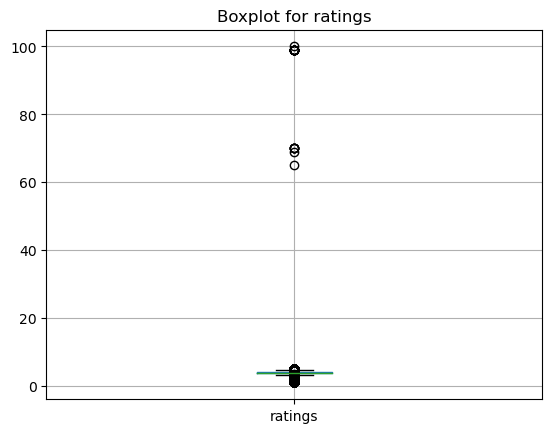

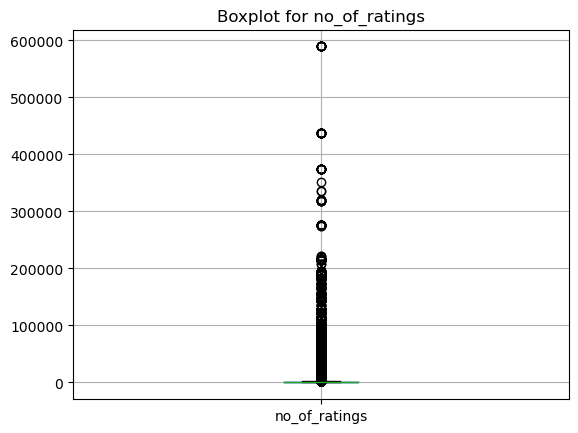

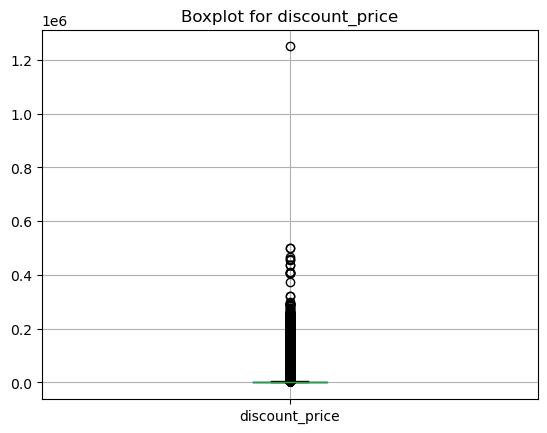

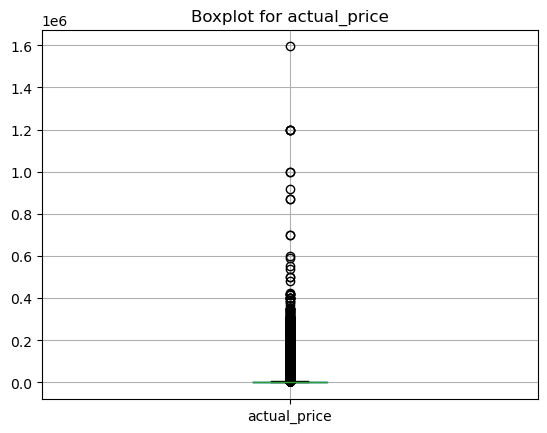

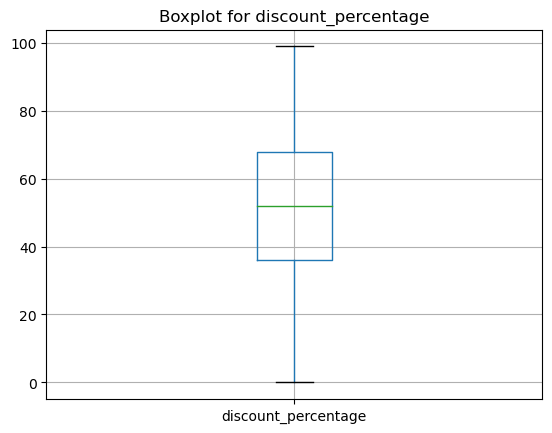

In [21]:
# Box plot for each numerical column
for col_name in numerical_columns:
    plt.figure()
    df_filtered.select(col(col_name).alias(col_name)).toPandas().boxplot()
    plt.title(f'Boxplot for {col_name}')
    plt.show()

# Check skewness

In [22]:
for col_name in numerical_columns:
    df_filtered.select(skewness(col(col_name))).show()

+-----------------+
|skewness(ratings)|
+-----------------+
|47.36678522681919|
+-----------------+

+-----------------------+
|skewness(no_of_ratings)|
+-----------------------+
|     40.376796723715586|
+-----------------------+

+------------------------+
|skewness(discount_price)|
+------------------------+
|       16.89939107311924|
+------------------------+

+----------------------+
|skewness(actual_price)|
+----------------------+
|    19.444596204033584|
+----------------------+

+-----------------------------+
|skewness(discount_percentage)|
+-----------------------------+
|          -0.2827391452627587|
+-----------------------------+



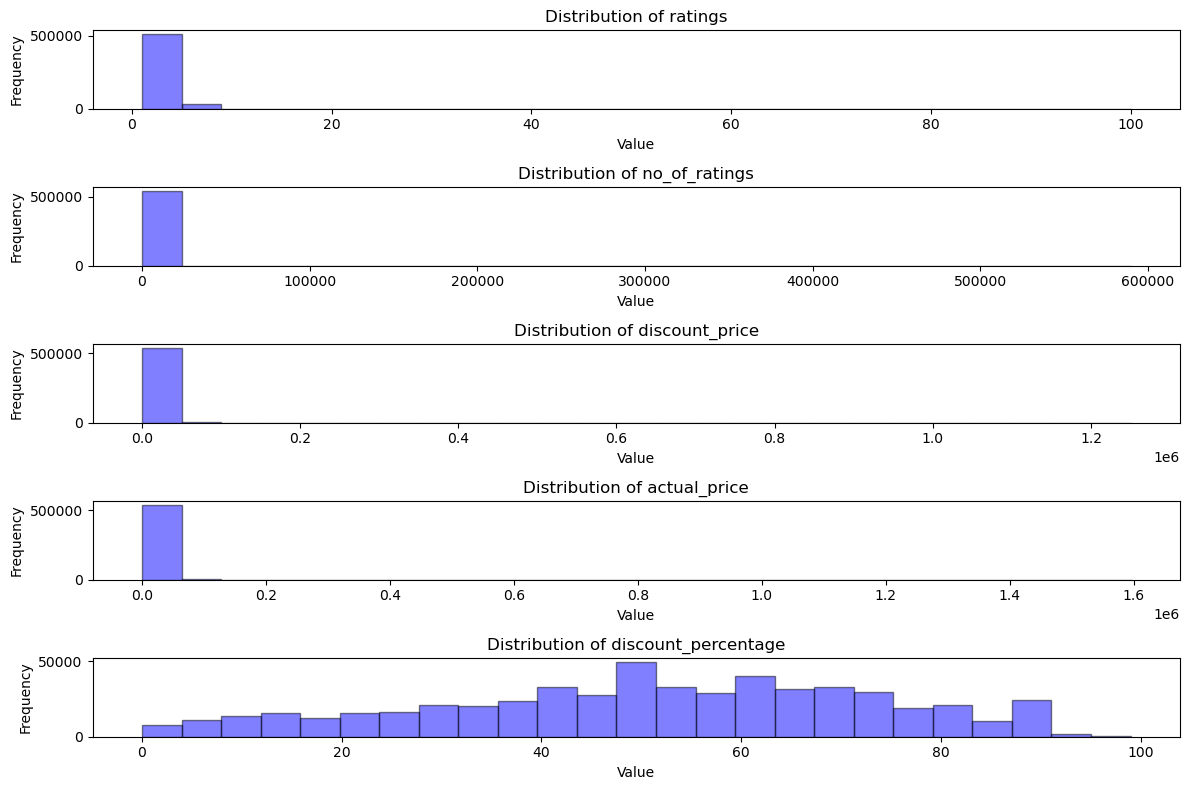

In [23]:
# Visualize skewness using a combined histogram for all columns
# Convert DataFrame columns to a Pandas DataFrame for plotting
data_values = df_filtered.select(*numerical_columns).toPandas()

# Plotting histograms
plt.figure(figsize=(12, 8))
for i, column in enumerate(numerical_columns):
    plt.subplot(len(numerical_columns), 1, i+1)
    plt.hist(data_values[column], bins=25, color='blue', edgecolor='black', alpha=0.5)
    plt.title(f"Distribution of {column}")
    plt.xlabel("Value")
    plt.ylabel("Frequency")

plt.tight_layout()
plt.show()